# Prerequisits

This tutorial is adapted from the `gradslam` repository. With it, we can explore the functionality of `gradslam` with Stereolabs own `SVO` file format as a dataset.

In [6]:
import gradslam as gs
import matplotlib.pyplot as plt
import numpy as np
import pyzed.sl as sl
import torch
from gradslam import Pointclouds, RGBDImages
from gradslam.slam import PointFusion
from torch.utils.data import DataLoader

from svo2gradslam.svo_dataset import SVOIterableDataset, sofa_filepath

# Load dataset

This package comes with a sample dataset, namely the `sofa.svo`. Others are available [here](https://support.stereolabs.com/hc/en-us/articles/1500009269601-Are-there-any-video-image-samples-from-the-ZED-products-that-I-can-see-and-test-before-the-purchase).

The dataset is implemented as a [`torch.utils.data.IterableDataset`](https://pytorch.org/docs/stable/data.html#iterable-style-datasets). It only supports iteration, as I found that seeking through the `svo` file took a lot of extra time. As a consequence, `__getitem__` is not implemented.

In [ ]:
svo_file = sofa_filepath()
dataset = SVOIterableDataset(str(svo_file), depth_mode=sl.DEPTH_MODE.NEURAL)

image, depth, intrinsics = next(iter(dataset))


# Visualize the color and depth image

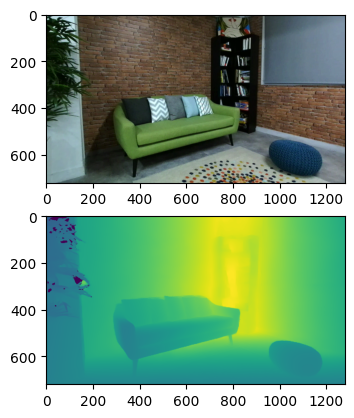

In [8]:
plt.subplot(211)
plt.imshow(image.squeeze())
plt.subplot(212)
plt.imshow(depth.squeeze())

# Batch loading using torch's DataLoader

In [9]:
# load dataset
loader = DataLoader(dataset=dataset, batch_size=5)
colors, depths, intrinsics = next(iter(loader))

colors.size()


torch.Size([5, 1, 720, 1280, 3])

In [4]:
# create rgbdimages object
rgbdimages = RGBDImages(colors, depths, intrinsics)
rgbdimages.plotly(0).show()

# Instantiation

> **_NOTE:_**  Make sure to have ran the [prerequisits](#Prerequisits) section before running this section.

The `RGBDImages` structures aims to contain batched frame tensors to more easily pass on to SLAM algorithms. It also supports easy computation of (both local and global) vertex maps and normal maps.

An `RGBDImages` object can be initialized from rgb images, depth images, instrinsics and (optionally) poses. `RGBDImages` supports both a channels first and a channels last representation.

In [5]:
print(f"colors shape: {colors.shape}")  # torch.Size([2, 8, 240, 320, 3])
print(f"depths shape: {depths.shape}")  # torch.Size([2, 8, 240, 320, 1])
print(f"intrinsics shape: {intrinsics.shape}")  # torch.Size([2, 1, 4, 4])
print('---')

# instantiation without poses
rgbdimages = RGBDImages(colors, depths, intrinsics)
print(rgbdimages.shape)  # (2, 8, 240, 320)
print('---')


colors shape: torch.Size([5, 1, 720, 1280, 3])
depths shape: torch.Size([5, 1, 720, 1280, 1])
intrinsics shape: torch.Size([5, 1, 4, 4])
---
(5, 1, 720, 1280)
---


# Indexing and slicing

> **_NOTE:_**  Make sure to have ran the [prerequisits](#Prerequisits) section before running this section.

Basic indexing and slicing of `RGBDImages` over the first (batch) dimension and the second (sequence length) dimension is supported.

In [6]:
# initalize RGBDImages
rgbdimages = RGBDImages(colors, depths, intrinsics)

# indexing
rgbdimages0 = rgbdimages[0, 0]
print(rgbdimages0.shape)  # (1, 1, 240, 320)
print('---')

# slicing
rgbdimages1 = rgbdimages[:2, :5]
print(rgbdimages1.shape)  # (2, 5, 240, 320)
print('---')

(1, 1, 720, 1280)
---
(2, 1, 720, 1280)
---


# Vertex maps and normal maps

> **_NOTE:_**  Make sure to have ran the [prerequisits](#Prerequisits) section before running this section.

This section demonstrates accessing vertex maps and normal maps from `RGBDImages`. Vertex maps are computed when accessing the `RGBDImages.vertex_maps` property, and are cached afterwards for additional access without further computation (and similarly with normal maps).

`RGBDImages` has both a local vertex map property (`RGBDImages.vertex_map`) which computes vertex positions with respect to each frame, as well as global vertex map (`RGBDImages.global_vertex_map`) which considers the poses of the `RGBDImages` object to compute the global vertex positions. A similar story is true for `RGBDimages.normal_map` and `RGBDImages.global_normal_map`.

torch.Size([5, 1, 720, 1280, 3])
torch.Size([5, 1, 720, 1280, 3])
torch.Size([5, 1, 720, 1280, 3])
torch.Size([5, 1, 720, 1280, 3])
---


/home/havarbra/miniconda3/envs/gradslam/lib/python3.10/site-packages/torch/functional.py:534: UserWarning:

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)



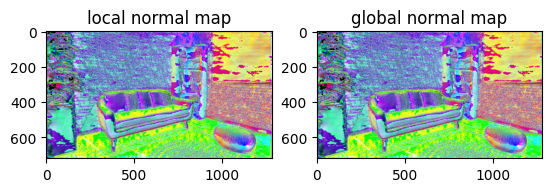

In [7]:
# initalize RGBDImages
rgbdimages = RGBDImages(colors, depths, intrinsics)

# compute vertex maps and normal maps
print(rgbdimages.vertex_map.shape)  # torch.Size([2, 8, 240, 320, 3])
print(rgbdimages.normal_map.shape)  # torch.Size([2, 8, 240, 320, 3])
print(rgbdimages.global_vertex_map.shape)  # torch.Size([2, 8, 240, 320, 3])
print(rgbdimages.global_normal_map.shape)  # torch.Size([2, 8, 240, 320, 3])
print('---')

# visualize
fig, ax = plt.subplots(1, 2)
ax[0].title.set_text('local normal map')
ax[0].imshow((rgbdimages.normal_map[-1, -1].numpy() * 255).astype(np.uint8))
ax[1].title.set_text('global normal map')
ax[1].imshow((rgbdimages.global_normal_map[-1, -1].numpy() * 255).astype(np.uint8))
plt.show()

# Transfer between GPU/CPU

> **_NOTE:_**  Make sure to have ran the [prerequisits](#Prerequisits) section before running this section.

`RGBDImages` support easy transfer between CPU and GPU. This operation transfers all tensors in the `RGBDImages` objects between CPU/GPU.

In [8]:
# initalize RGBDImages
rgbdimages = RGBDImages(colors, depths, intrinsics)

if torch.cuda.is_available():
    # transfer to GPU
    rgbdimages = rgbdimages.to("cuda")
    rgbdimages = rgbdimages.cuda()  # equivalent to rgbdimages.to("cuda")
    print(rgbdimages.rgb_image.device)  # "cuda:0"
    print('---')

# transfer to CPU
rgbdimages = rgbdimages.to("cpu")
rgbdimages = rgbdimages.cpu()  # equivalent to rgbdimages.to("cpu")
print(rgbdimages.rgb_image.device)  # "cpu"

cuda:0
---
cpu


# Detach and clone tensors

> **_NOTE:_**  Make sure to have ran the [prerequisits](#Prerequisits) section before running this section.

`RGBDImages.detach` returns a new `RGBDImages` object such that all internal tensors of the new object do not require grad. `RGBDImages.clone()` returns a new `RGBDImages` object such that all the internal tensors are cloned.

In [9]:
# initalize RGBDImages
rgbdimages = RGBDImages(colors.requires_grad_(True),
                        depths.requires_grad_(True),
                        intrinsics.requires_grad_(True))

# clone
rgbdimages1 = rgbdimages.clone()
print(torch.allclose(rgbdimages1.rgb_image, rgbdimages.rgb_image))  # True
print(rgbdimages1.rgb_image is rgbdimages.rgb_image)  # False
print('---')

# detach
rgbdimages2 = rgbdimages.detach()
print(rgbdimages.rgb_image.requires_grad)  # True
print(rgbdimages2.rgb_image.requires_grad)  # False

RuntimeError: only Tensors of floating point dtype can require gradients

# Channels first and channels last representation

> **_NOTE:_**  Make sure to have ran the [prerequisits](#Prerequisits) section before running this section.

`RGBDImages` supports both a channels first and a channels last representation. These representations can be transformed to one another with `to_channels_first()` and `to_channels_last()` methods.

In [10]:
# initalize RGBDImages
rgbdimages = RGBDImages(colors, depths, intrinsics)
print(rgbdimages.rgb_image.shape)  # torch.Size([2, 8, 240, 320, 3])
print('---')

# convert to channels first representation
rgbdimages1 = rgbdimages.to_channels_first()
print(rgbdimages1.rgb_image.shape)  # torch.Size([2, 8, 3, 240, 320])
print('---')

# convert to channels last representation
rgbdimages2 = rgbdimages1.to_channels_last()
print(rgbdimages2.rgb_image.shape)  # torch.Size([2, 8, 240, 320, 3])
print('---')

torch.Size([5, 1, 720, 1280, 3])
---
torch.Size([5, 1, 3, 720, 1280])
---
torch.Size([5, 1, 720, 1280, 3])
---


# Visualization

> **_NOTE:_**  Make sure to have ran the [prerequisits](#Prerequisits) section before running this section.

For easy and quick visualization of `RGBDImages`, one can use the `.plotly(batch_index)` method:

In [11]:
# initalize RGBDImages
rgbdimages = RGBDImages(colors, depths, intrinsics)

# visualize
rgbdimages.plotly(0).show()